<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
!pip install tensorflow-addons

     |████████████████████████████████| 1.1 MB 5.0 MB/s 


In [9]:
!pip install lifelines
!pip install scikit-plot

     |████████████████████████████████| 349 kB 5.1 MB/s 
     |████████████████████████████████| 56 kB 2.2 MB/s 
     |████████████████████████████████| 38.1 MB 2.4 MB/s 
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4048 sha256=1d564276f20ce005cae7d13b07377265a7b1930125b827eddfad99452a564780
  Stored in directory: /root/.cache/pip/wheels/9f/01/ee/1331593abb5725ff7d8c1333aee93a50a1c29d6ddda9665c9f
Successfully built autograd-gamma
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
  Attempting uninstall: astor
    Found existing installation: astor 0.8.1
    Uninstalling astor-0.8.1:
      Successfully uninstalled astor-0.8.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires astor~=0.8.1, but you ha

In [1]:
import tensorflow as tf

from tensorflow import keras
from sklearn.model_selection import train_test_split
from keras import backend as K
from tensorflow.keras.layers import StringLookup
from tqdm.keras import TqdmCallback
from tqdm.auto import tqdm
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('default')
plt.style.use('seaborn-white')

models = tf.keras.models
layers = tf.keras.layers
preprocessing = tf.keras.preprocessing

tqdm.pandas()

In [55]:
def mse_nan(y_true, y_pred):

    masked_true = tf.where(tf.math.is_nan(
        y_true), tf.zeros_like(y_true), y_true)
    masked_pred = tf.where(tf.math.is_nan(
        y_true), tf.zeros_like(y_true), y_pred)
    is_empty = tf.equal(tf.size(masked_true), 0)

    if is_empty:
        error = tf.constant(0.0)
        return error

    error = K.mean(K.square(masked_pred - masked_true), axis=-1)
    return error


class LossWithMemoryCallback(tf.keras.callbacks.Callback):
    def __init__(self, kd_var, ki_var, ic_var, ec_var, discount=0.01):
        self.kd_var = kd_var
        self.ki_var = ki_var
        self.ic_var = ic_var
        self.ec_var = ec_var

        self.discount = discount

    def on_epoch_end(self, epoch, logs):
        self.kd_var = logs['Kd_loss']*self.discount
        self.ki_var = logs['Ki_loss']*self.discount
        self.ic_var = logs['IC50_loss']*self.discount
        self.ec_var = logs['EC50_loss']*self.discount


def mse_nan_with_memory(y_true, y_pred, var):

    masked_true = tf.where(tf.math.is_nan(y_true), tf.zeros_like(y_true), y_true)
    masked_pred = tf.where(tf.math.is_nan(y_true), tf.zeros_like(y_true), y_pred)
    is_empty = tf.equal(tf.size(masked_true), 0)

    if is_empty:
        #print('in_use')
        error = var
        return error

    error = K.mean(K.square(masked_pred - masked_true), axis=-1)
    return error

In [51]:
def get_optimizer():
    optimizer = tf.keras.optimizers.Adadelta(learning_rate=1.0)
    return optimizer


def get_model(num_shared=2, units=64, rate=0.3, loss_weights=None, kvars = {}):

    sm = layers.Input(shape=(100, ), name='D_Inp')
    aa = layers.Input(shape=(1000, ), name='T_Inp')

    emsm0 = layers.Embedding(53,
                             128,
                             trainable=True,
                             name='D_Emb',
                             mask_zero=True)(sm)
    emaa0 = layers.Embedding(22,
                             128,
                             trainable=True,
                             name='T_Emb',
                             mask_zero=True)(aa)

    cnvsm1 = layers.Conv1D(32, 3, name='D_L1')(emsm0)
    cnvaa1 = layers.Conv1D(32, 3, name='T_L1')(emaa0)

    cnvsm2 = layers.Conv1D(64, 3, name='D_L2')(cnvsm1)
    cnvaa2 = layers.Conv1D(64, 3, name='T_L2')(cnvaa1)

    gmpsm = layers.GlobalMaxPool1D(name='D_Gmp')(cnvsm2)
    gmpaa = layers.GlobalMaxPool1D(name='T_Gmp')(cnvaa2)

    C1 = layers.concatenate([gmpsm, gmpaa], axis=-1, name='C1')

    S1 = layers.Dense(512, activation='relu', name='S1')(C1)
    S1 = layers.Dropout(rate)(S1)

    S2 = layers.Dense(512, activation='relu', name='S2')(S1)
    S2 = layers.Dropout(rate)(S2)

    S3 = layers.Dense(512, activation='relu', name='S3')(S2)
    S3 = layers.Dropout(rate)(S3)

    Kd = layers.Dense(units, activation='relu', name='S1_Kd')(S3)
    Kd = layers.Dropout(rate)(Kd)

    Ki = layers.Dense(units, activation='relu', name='S1_Ki')(S3)
    Ki = layers.Dropout(rate)(Ki)

    IC50 = layers.Dense(units, activation='relu', name='S1_IC50')(S3)
    IC50 = layers.Dropout(rate)(IC50)

    EC50 = layers.Dense(units, activation='relu', name='S1_EC50')(S3)
    EC50 = layers.Dropout(rate)(EC50)

    IA = layers.Dense(units, activation='relu', name='S1_IA')(S3)
    IA = layers.Dropout(rate)(IA)

    pH = layers.Dense(units, activation='relu', name='S1_pH')(S3)
    pH = layers.Dropout(rate)(pH)

    out1 = layers.Dense(1, activation='linear', name='Kd')(Kd)
    out2 = layers.Dense(1, activation='linear', name='Ki')(Ki)
    out3 = layers.Dense(1, activation='linear', name='IC50')(IC50)
    out4 = layers.Dense(1, activation='linear', name='EC50')(EC50)
    out5 = layers.Dense(1, activation='sigmoid', name='IA')(IA)
    out6 = layers.Dense(1, activation='linear', name='pH')(pH)

    model = models.Model(inputs=[sm, aa],
                         outputs=[out1, out2, out3, out4, out5, out6])

    losses = {
        "Kd": lambda yt, yp: mse_nan_with_memory(yt, yp, kvars['kd']),
        "Ki": lambda yt, yp: mse_nan_with_memory(yt, yp, kvars['ki']),
        "IC50": lambda yt, yp: mse_nan_with_memory(yt, yp, kvars['ic']),
        "EC50": lambda yt, yp: mse_nan_with_memory(yt, yp, kvars['ec']),
        "pH": mse_nan,
        "IA": "binary_crossentropy",
    }

    metrics = {"IA": tf.keras.metrics.AUC()}

    model.compile(loss=losses, optimizer=get_optimizer(), metrics=metrics, loss_weights=loss_weights)
    model.summary()
    return model

In [52]:
tf.keras.backend.clear_session()
np.random.seed(7)
tf.random.set_seed(7)

loss_weights = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

kd_var = K.variable(0.0)
ki_var = K.variable(0.0)
ic_var = K.variable(0.0)
ec_var = K.variable(0.0)

kvars = {}
kvars['kd'] = kd_var
kvars['ki'] = ki_var
kvars['ic'] = ic_var
kvars['ec'] = ec_var

model = get_model(rate=0.3, loss_weights=loss_weights, kvars = kvars)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 D_Inp (InputLayer)             [(None, 100)]        0           []                               
                                                                                                  
 T_Inp (InputLayer)             [(None, 1000)]       0           []                               
                                                                                                  
 D_Emb (Embedding)              (None, 100, 128)     6784        ['D_Inp[0][0]']                  
                                                                                                  
 T_Emb (Embedding)              (None, 1000, 128)    2816        ['T_Inp[0][0]']                  
                                                                                              

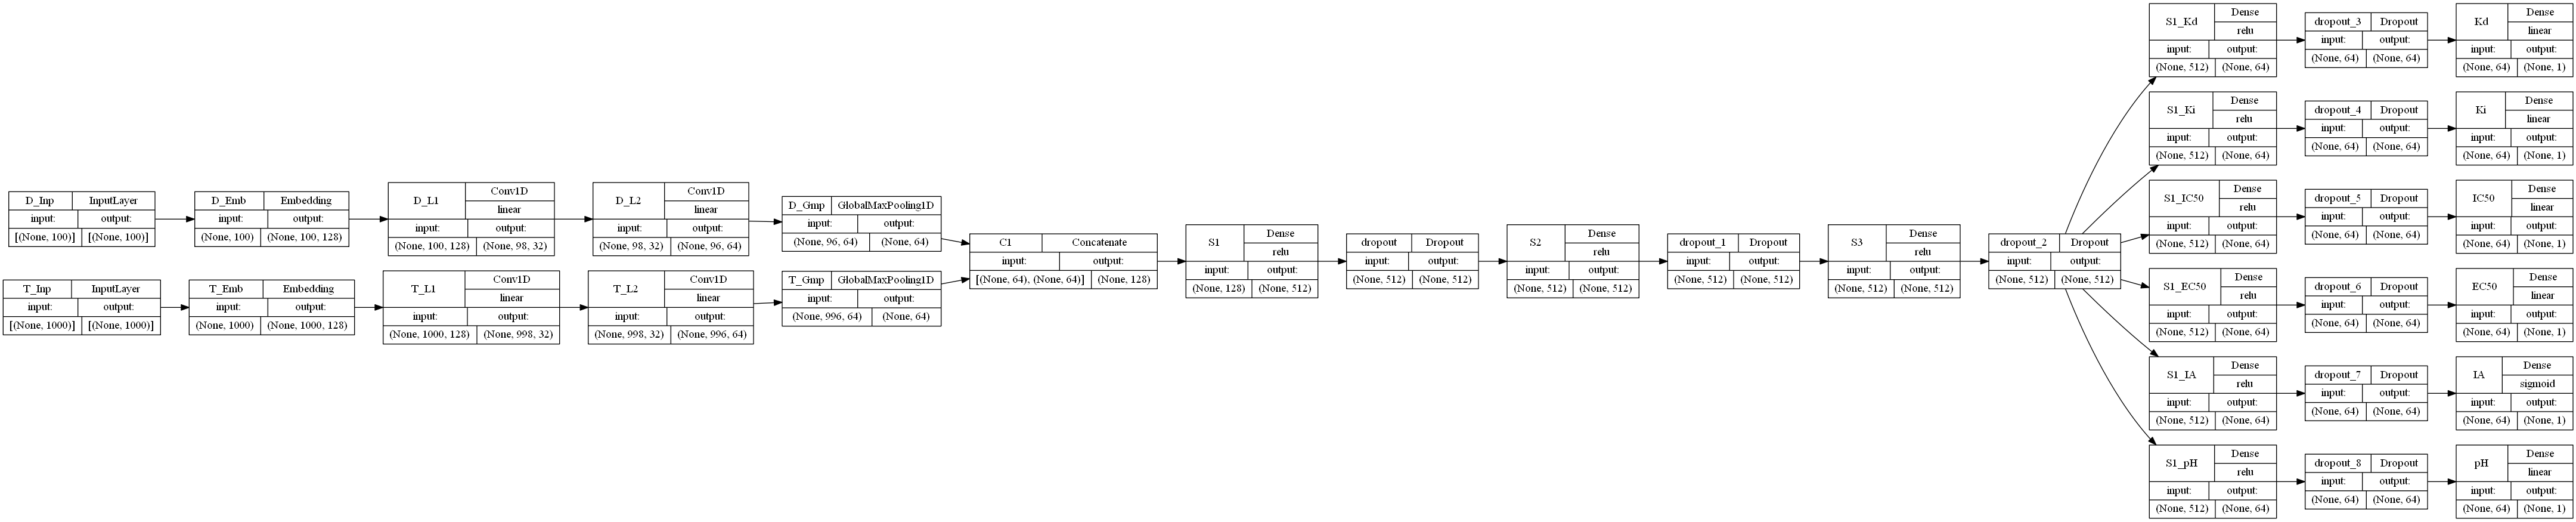

In [28]:
tf.keras.utils.plot_model(model, rankdir='LR',
                          show_shapes=True,
                          show_layer_activations=True)

In [9]:
CHARPROTSET = dict([('A', 1), ('G', 2), ('L', 3), ('M', 4), ('S', 5), ('T', 6),
                    ('E', 7), ('Q', 8), ('P', 9), ('F', 10), ('R', 11),
                    ('V', 12), ('D', 13), ('I', 14), ('N', 15), ('Y', 16),
                    ('H', 17), ('C', 18), ('K', 19), ('W', 20), ('X', 21)])

CHARCANSMISET = dict([(')', 1), ('(', 2), ('1', 3), ('C', 4), ('c', 5),
                      ('O', 6), ('2', 7), ('N', 8), ('=', 9), ('n', 10),
                      ('3', 11), ('-', 12), ('4', 13), ('F', 14), ('S', 15),
                      ('[', 16), (']', 17), ('l', 18), ('H', 19), ('s', 20),
                      ('#', 21), ('o', 22), ('5', 23), ('B', 24), ('r', 25),
                      ('+', 26), ('6', 27), ('P', 28), ('.', 29), ('I', 30),
                      ('7', 31), ('e', 32), ('i', 33), ('a', 34), ('8', 35),
                      ('K', 36), ('A', 37), ('9', 38), ('T', 39), ('g', 40),
                      ('R', 41), ('Z', 42), ('%', 43), ('0', 44), ('u', 45),
                      ('V', 46), ('b', 47), ('t', 48), ('L', 49), ('*', 50),
                      ('d', 51), ('W', 52)])

In [10]:
class Gen:
    def __init__(self,
                 data,
                 map_smiles,
                 map_aa,
                 shuffle=True,
                 test_only=False,
                 len_drug=100,
                 len_target=1000,
                 window=False):
        self.data = data
        self.map_smiles = map_smiles
        self.map_aa = map_aa
        self.shuffle = shuffle
        self.test_only = test_only
        self.len_drug = len_drug
        self.len_target = len_target
        self.size = self.data.shape[0]
        self.inds = list(range(self.size))
        if self.shuffle:
            random.shuffle(self.inds)

        self.window = window

        self.gen = self._get_inputs()

    def _get_inputs(self):
        seen = 0
        while seen < self.size:
            ind = self.inds[seen]
            sample = self.data.iloc[ind, :].values.tolist()
            sample[0] = self.map_smiles[sample[0]]
            sample[1] = self.map_aa[sample[1]]

            if self.window:
                ld = max(0, (len(sample[0]) - self.len_drug))
                lt = max(0, (len(sample[1]) - self.len_target))
                dstart = random.randint(0, ld)
                tstart = random.randint(0, lt)

                sample[0] = sample[0][dstart:dstart + self.len_drug]
                sample[1] = sample[1][tstart:dstart + self.len_target]

            yield sample
            seen += 1
            if seen == self.size:
                if self.shuffle:
                    random.shuffle(self.inds)
                seen = 0

    def get_batch(self, batch_size):
        while True:
            BATCH = []
            for _ in range(batch_size):
                sample = next(self.gen)
                for k, value in enumerate(sample):
                    if len(BATCH) < (k+1):
                        BATCH.append([])
                    BATCH[k].append(value)

            BATCH[0] = preprocessing.sequence.pad_sequences(BATCH[0], self.len_drug)
            BATCH[1] = preprocessing.sequence.pad_sequences(BATCH[1], self.len_target)
            
            for k in range(2, len(BATCH)):
                BATCH[k] = np.array(BATCH[k]).flatten()

            if not self.test_only:
                yield [BATCH[0],  BATCH[1]], [BATCH[k] for k in range(2, len(BATCH))]
            else:
                yield [BATCH[0],  BATCH[1]], [BATCH[k]*0 for k in range(2, len(BATCH))]

In [11]:
data = pd.read_csv("data_full_05_pH.zip", compression='zip')
order = [
    'smiles', 'target', 'p1Kd', 'p1Ki', 'p1IC50', 'p1EC50', 'is_active', 'pH'
]
data = data[order]

In [12]:
data = data.sample(frac=1, random_state = 7)
data.head()

,smiles,target,p1Kd,p1Ki,p1IC50,p1EC50,is_active,pH
618389,Nc1ccc(-c2nc(N3CCOCC3)c3cnn(C4CCN(Cc5ccccc5)CC...,MPPRPSSGELWGIHLMPPRILVECLLPNGMIVTLECLREATLITIK...,NaN,NaN,7.221836,NaN,0.0,NaN
30622,CCCNC(=O)C1CC(c2ccc(C(F)(F)F)cc2)=NO1,MIFLYQVVHFILFTSVSGECVTQLLKDTCFEGGDITTVFTPSAKYC...,NaN,NaN,9.567024,NaN,0.0,7.4
754564,COc1cc(-c2cn(C3CC(C(F)(F)F)CCN(Cc4ccccc4)C3=O)...,MPVRRGHVAPQNTFLDTIIRKFEGQSRKFIIANARVENCAVIYCND...,NaN,NaN,8.609043,NaN,0.0,NaN
900001,O=C(C=Cc1cc(Cl)ccc1-n1cnnn1)NC1CC=CCCC(=O)Nc2c...,MIFLYQVVHFILFTSVSGECVTQLLKDTCFEGGDITTVFTPSAKYC...,NaN,1.526056,NaN,NaN,1.0,NaN
859237,N=C(N)Nc1ccc(CNc2cnc3cc(C(=O)NCCO)ccn23)cc1,MRALLARLLLCVLVVSDSKGSNELHQVPSNCDCLNGGTCVSNKYFS...,NaN,NaN,5.905362,NaN,1.0,NaN


In [13]:
data.dropna().shape

(44, 8)

In [14]:
SMILES = {}
for smiles in tqdm(data['smiles'].unique()):
    SMILES[smiles] = [CHARCANSMISET[s] for s in smiles]

AA = {}
for aa in tqdm(data['target'].unique()):
    AA[aa] = [CHARPROTSET[a.upper()] for a in aa]

  0%|          | 0/574406 [00:00<?, ?it/s]

  0%|          | 0/1902 [00:00<?, ?it/s]

In [15]:
X_train, X_test = train_test_split(data,
                                   test_size=0.1,
                                   shuffle=True,
                                   random_state=7,
                                   stratify=data['is_active'])

X_train, X_valid = train_test_split(X_train,
                                    test_size=0.1,
                                    shuffle=True,
                                    random_state=7,
                                    stratify=X_train['is_active'])

X_train.shape[0], X_test.shape[0], X_valid.shape[0]

(733937, 90610, 81549)

In [16]:
X_train.head()

,smiles,target,p1Kd,p1Ki,p1IC50,p1EC50,is_active,pH
541244,Cc1cccc(-n2cc3c(n2)c(NC(=O)Cc2ccccc2)nc2ccccc2...,MPPSISAFQAAYIGIEVLIALVSVPGNVLVIWAVKVNQALRDATFC...,NaN,4.110874,NaN,NaN,1.0,NaN
321626,CC(C)(O)CCNC(=O)N1C(=O)N(c2cccc(C(F)(F)F)c2)C2...,MTLGRRLACLFLACVLPALLLGGTALASEIVGGRRARPHAWPFMVS...,NaN,NaN,0.741937,NaN,1.0,NaN
206291,CN(C)C1CN(c2cnc3ccc(-c4ccc5oc(N)nc5c4)cc3n2)C1,MELENYKQPVVLREDNCRRRRRMKPRSAAASLSSMELIPIEFVLPT...,NaN,NaN,9.210440,NaN,0.0,NaN
21827,Cc1nn(C(=O)c2ccc(Cl)cc2)c(C)c1Cl,MLGITVLAALLACASSCGVPSFPPNLSARVVGGEDARPHSWPWQIS...,NaN,NaN,8.455531,NaN,0.0,NaN
135842,CC1(C)CC(NC(=O)Nc2ccc3c(c2)NC(=O)CC3)c2cccc(C(...,MKKWSSTDLGAAADPLQKDTCPDPLDGDPNSRPPPAKPQLSTAKSR...,NaN,NaN,8.188967,NaN,0.0,NaN


In [53]:
batch_size = 128

trg = Gen(X_train, SMILES, AA)
trg = trg.get_batch(batch_size)

vag = Gen(X_valid, SMILES, AA)
vag = vag.get_batch(batch_size)

In [18]:
# for batch in trg:
#     break

# batch

In [19]:
steps_per_epoch = X_train.shape[0] // batch_size
valid_steps = X_valid.shape[0] // batch_size

In [47]:
filepath = "CNN_basic_with_memory_{epoch:02d}-{val_loss:.2f}.h5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath,
                                                monitor='val_loss',
                                                verbose=1,
                                                save_best_only=False,
                                                mode='auto',
                                                save_weights_only=True)

In [56]:
history = model.fit(trg,
                    validation_data=vag,
                    steps_per_epoch=steps_per_epoch,
                    validation_steps=valid_steps,
                    verbose=0,
                    callbacks=[TqdmCallback(), checkpoint, LossWithMemoryCallback(kd_var, ki_var, ic_var, ec_var)],
                    epochs=50)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Instructions for updating:
Use most_specific_common_supertype instead.

Epoch 1: saving model to CNN_basic_with_memory_01-7.77.h5

Epoch 2: saving model to CNN_basic_with_memory_02-6.96.h5

Epoch 3: saving model to CNN_basic_with_memory_03-6.50.h5

Epoch 4: saving model to CNN_basic_with_memory_04-6.36.h5

Epoch 5: saving model to CNN_basic_with_memory_05-6.26.h5

Epoch 6: saving model to CNN_basic_with_memory_06-5.72.h5

Epoch 7: saving model to CNN_basic_with_memory_07-5.93.h5

Epoch 8: saving model to CNN_basic_with_memory_08-5.70.h5

Epoch 9: saving model to CNN_basic_with_memory_09-5.71.h5

Epoch 10: saving model to CNN_basic_with_memory_10-5.57.h5

Epoch 11: saving model to CNN_basic_with_memory_11-5.52.h5

Epoch 12: saving model to CNN_basic_with_memory_12-5.54.h5

Epoch 13: saving model to CNN_basic_with_memory_13-5.37.h5

Epoch 14: saving model to CNN_basic_with_memory_14-5.31.h5

Epoch 15: saving model to CNN_basic_with_memory_15-5.42.h5

Epoch 16: saving model to CNN_basic_w

In [70]:
model.load_weights('CNN_basic_with_memory_50-4.96.h5')
model.compile(optimizer=get_optimizer())
model.save("cnn_with_memory.hdf5")

In [18]:
# !rm *.h5 -r

In [19]:
# history.history

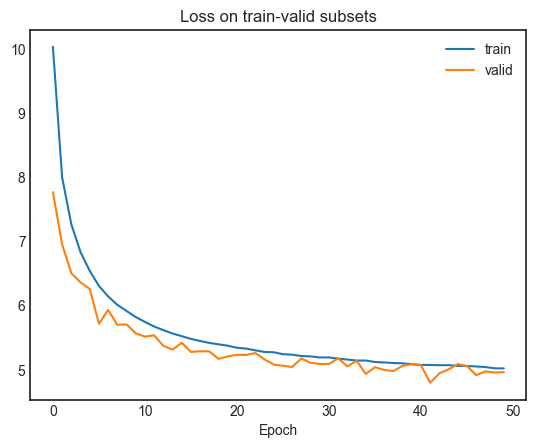

In [58]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='valid')
plt.xlabel('Epoch')
plt.title('Loss on train-valid subsets')
plt.legend()

In [59]:
def get_batch_size(S):
    mbs = 1
    for i in range(1, min(64, S)):
        if S % i == 0:
            mbs = i
    assert S % mbs == 0

    return mbs

In [60]:
mbs = get_batch_size(X_test.shape[0])
mbs

41

In [61]:
teg = Gen(X_test, SMILES, AA, shuffle=False, test_only=True)
teg = teg.get_batch(mbs)

In [62]:
prediction = model.predict(teg, steps=X_test.shape[0] // mbs, verbose=1)

2210/2210 [==============================] - 88s 38ms/step


In [63]:
from sklearn.metrics import mean_squared_error
from lifelines.utils import concordance_index
from scipy import stats

In [64]:
def get_scores(y_true, y_pred):
    mse = np.round(mean_squared_error(y_true, y_pred), 3)
    rmse = np.round(mse**0.5, 3)
    ci = np.round(concordance_index(y_true, y_pred), 3)
    pearson = np.round(stats.pearsonr(y_true, y_pred)[0], 3)
    spearman = np.round(stats.spearmanr(y_true, y_pred)[0], 3)

    res = f"rmse={rmse}, mse={mse},\npearson={pearson}, spearman={spearman},\nci={ci}"

    return res

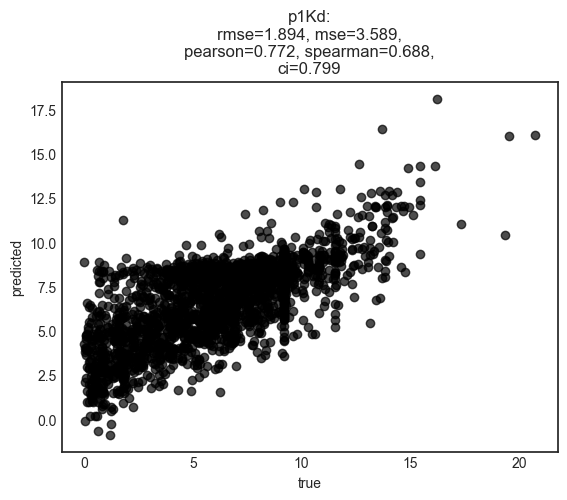

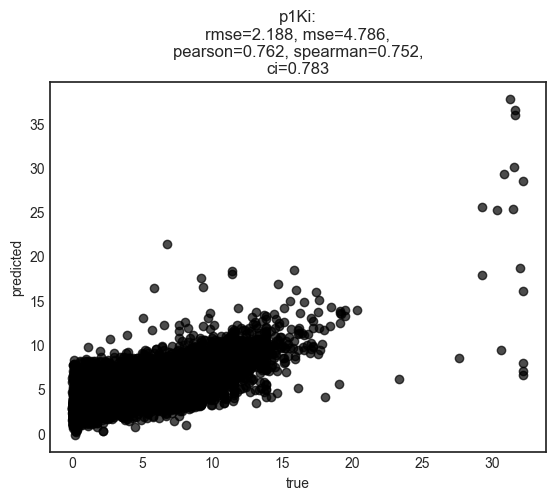

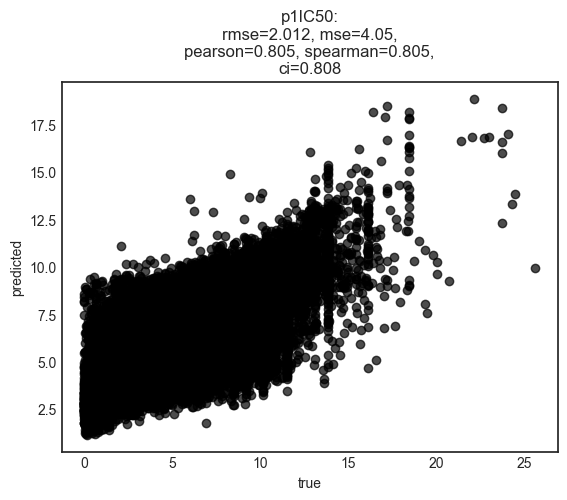

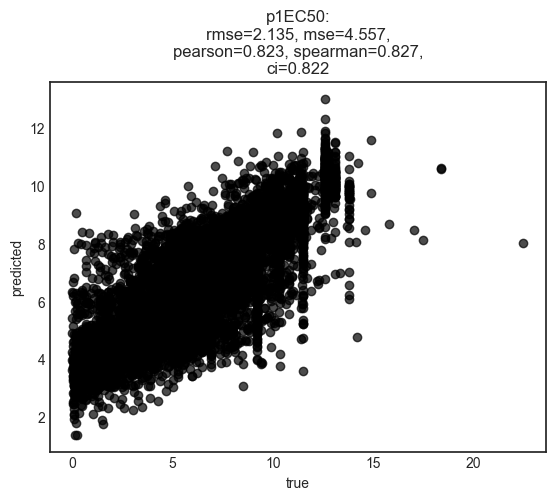

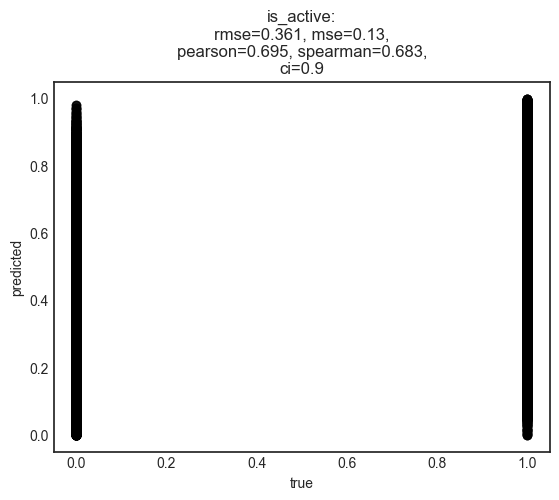

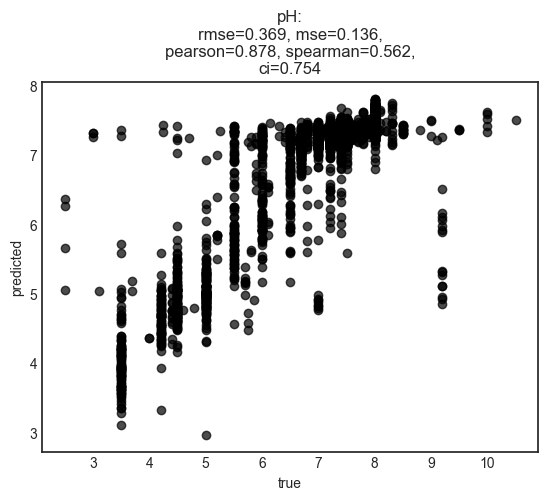

In [71]:
for k, col in enumerate(
    ['p1Kd', 'p1Ki', 'p1IC50', 'p1EC50', 'is_active', 'pH']):
    plt.scatter(X_test[col], prediction[k], alpha=0.7, c='k')
    plt.xlabel('true')
    plt.ylabel('predicted')
    y_true = X_test[col][X_test[col].notna()]
    y_pred = prediction[k][X_test[col].notna()].ravel()
    plt.title(col + ":\n" + get_scores(y_true, y_pred))
    plt.show()  # 74.6

In [66]:
import scikitplot as skplt

A:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


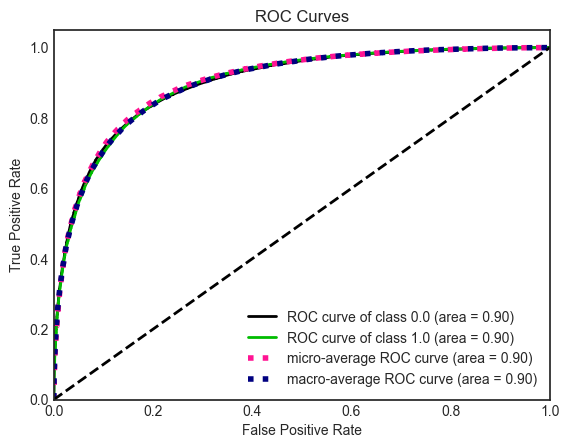

In [67]:
p = prediction[-2].ravel().tolist()
probas = np.zeros((len(p), 2))
probas[:, 1] = p
probas[:, 0] = 1
probas[:, 0] = probas[:, 0] - p
skplt.metrics.plot_roc_curve(X_test['is_active'].values.ravel().tolist(),
                             probas)
plt.show()

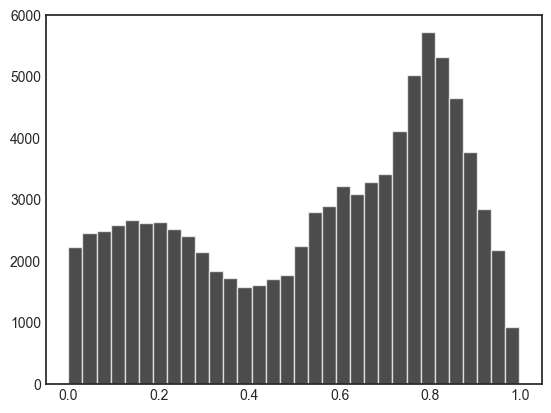

In [68]:
plt.hist(prediction[-2].ravel(), bins=32, edgecolor='w', color='k', alpha=0.7);